<table>
<table border = 5  align = center bgcolor="white" cellspacing="10px">

<tr>
<td><a href="https://drive.google.com/file/d/1--wnF2vQE2nDQ8rC8iMa2A2Sk1tNwPwz/view?usp=sharing"> <img alt="Colaboratory logo" width="150px"  src="https://miro.medium.com/max/986/1*S2AyJcdw8EPcn7gwDVSBCA.png" align="left" hspace="10px" vspace="0px" /> </a> </td>
   
    
 
<td></td>
    
<td><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitmilab.redclara.net%2FhalleyUIS%2Fmoncora.git/4d1344cb6f0df9a23bce6fe9d70812719aeb0fe5?urlpath=lab%2Ftree%2FBook%2FJupyter_Notebooks%2FDatosII_a.ipynb"><img src="https://mybinder.org/static/images/logo_social.png" alt="Alternative text" width="150px"  /></a>
</td>

</tr>

</table>
    
<br>

---
    
# <strong>Los datos hablan II. Diagrama de cajas y bigotes</strong>

In [1]:
import pandas as pd                   # Librería de manejo de datos en DataFrames
import numpy as np                    # Librería de cálculos matemáticos con Arrays
import matplotlib.pyplot as plt       # Librería de gráficas
import matplotlib.dates as mdates     # Módulo de manejo de fechas en las etiquetas de una gráfica
from MakeSens import MakeSens         # Libería de descarga de datos del proyecto RACIMO-MONCORA

## **Importación de datos**

In [2]:
fecha_inicio = "2023-08-14 00:00:00"
fecha_fin = "2023-09-17 23:59:00"
estacion = "mE1_00008"                      # FCUIS: 'mE1_00008'
frecuencia = "1H"                          # 1T: 1 unidad de tiempo / minuto, 1H: 1 hora, 1D: 1 día

data = MakeSens.download_data(estacion, fecha_inicio, fecha_fin, frecuencia)

## **Selección de datos Material Particulado**

In [4]:
# Selección de columnas
columnas = ["pm10_1", "pm10_2","pm25_1", "pm25_2", "pm1_1", "pm1_2", 'ts']
pm_data = data[columnas]

# Ajuste del índice de la tabla de datos. Ponemos el tiempo como índice:
pm_data = pm_data.set_index('ts')
pm_data.index = pd.to_datetime(pm_data.index)

#pm_data

## **Limpiando datos**

Para que sea un poco más sencillo manejar nuestros datos, definiremos un nuevo DataFrame para almacenar solo con las variables de material particulado. Luego convertiremos el índice de los datos a formato de fecha y hora con la función ```to_datetime()```.

In [5]:
columnas = pm_data.columns # Guardamos los nombres de las columnas en una lista
for col in columnas:                                             # Iteramos entre cada columna
    pm_data[col] = pm_data[col].where(pm_data[col]<120, np.nan)  # Reemplazamos los valores mayores a 120 por NaN

In [6]:
show = False         #  Muestra la grafica si es verdadero.
if show:
    # Graficamos los datos limpios de pm10 
    fig = plt.figure(figsize=(12, 6))            # Figura
    ax = fig.gca()                               # Ejes
    plt.plot(pm_data.index, pm_data['pm10_1'], '.',label = 'Sensor 1', alpha=0.7)   # Datos pm10_1
    plt.plot(pm_data.index, pm_data['pm10_2'], '.',label = 'Sensor 2', alpha=0.7)   # Datos pm10_2

    # Configuramos etiquetas
    plt.title("Datos de PM 10", fontsize=20)
    plt.xlabel("Fecha",         fontsize=15)
    plt.ylabel(r"Concentración [$\mu g/m^3$]", fontsize=15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))     # Formato de fecha: %b: mes, %d: día, %Y: año
    plt.grid(alpha=0.5, linestyle="--")
    plt.legend(fontsize=12)
    plt.show()

## **Ratios**

In [9]:
pm_d = pm_data.resample('D').mean()             # Datos diarios
pm_d['semana'] = pm_d.index.isocalendar().week # Columna semana del año
pm_d['dia'] = pm_d.index.isocalendar().day     # Columna día del año

## Columna EnSemana
clase = pm_d['dia'].values
for i in range(len(clase)):
    if clase[i] in [1,2,3,4,5]:
        clase[i] = 1
    else:
        clase[i] = 0
pm_d['clase'] = pd.Series(clase, index=pm_d.index)
del pm_d['dia']

## Agrupar por semana y por clase
pm_s = pm_d.groupby(['semana','clase']).mean()

## Calcular ratios
columnas = pm_s.columns          # Columnas
semanas = pm_d.semana.unique()   # Semanas

# Eliminamos semanas incompletas
if 0 not in list(pm_s.loc[semanas[-1]].index):
    semanas = semanas[:-1]
if 1 not in list(pm_s.loc[semanas[0]].index):
    semanas = semanas[1:] 
 
Ratios = {}
for col in columnas:
    Ratios[col] = []
for semana in semanas:
    for col in columnas:
        f = (pm_s.loc[semana,0] / pm_s.loc[semana,1])[col]
        Ratios[col].append(f)
Ratios = pd.DataFrame(Ratios,index=semanas)

## Columna de fechas
import datetime
date = []
for s in semanas:
    date.append(datetime.date.fromisocalendar(2023, s, 1))
Ratios['date'] = pd.to_datetime(date)

### **Gráfica de bigotes**

Finalmente, vamos a graficar los datos obtenidos utilizando la función ```.boxplot()``` de Pandas. Esta función nos permite visualizar la distribución de los datos. En este caso, vamos a graficar la distribución de los ratios calculados para cada semana.


<div class="alert alert-block alert-info">
<b>¿Qué es un gráfico de bigotes?</b> Un gráfico de bigotes es un gráfico que muestra la distribución de los datos en <b>cuartiles</b>, resaltando el promedio y los valores atípicos. Las líneas que se extienden fuera de las cajas, llamadas "bigotes", muestran la <b>variabilidad</b> fuera del valor promedio de los datos y cualquier valor atípico que pueda estar presente en los datos. Los bigotes se pueden mostrar de diferentes maneras, dependiendo de la biblioteca que se utilice. En este caso, vamos a utilizar la función .boxplot() de Matplotlib

Por otra parte, ya hemos trabajado los cuartiles. Un cuartil es un valor que divide un conjunto de datos en cuatro partes iguales. Los cuartiles se pueden calcular utilizando la función ```.quantile()``` de Pandas. Por ejemplo, el primer cuartil es el primer conjunto de datos tras efectuar la división. Es decir, el 25% de los datos se encuentran por debajo del primer cuartil mientras que el 75% de los datos se encuentran por encima del primer cuartil. 
</div>  




[Text(0, 1, 'FCUIS')]

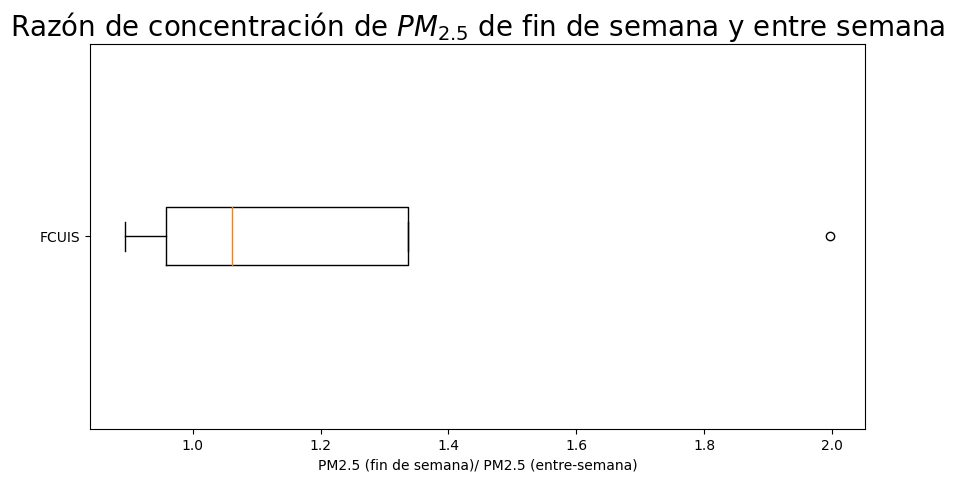

In [22]:
#Analicemos nuetro resultado con una gráfica de bigotes
plt.figure(figsize=(10,5))

#Iniciamos la gráfica de bigotes
plt.boxplot(x = Ratios['pm25_1'].values,
            vert=False, 
            #meanline=True, showmeans=True, 
           )
plt.xlabel("PM2.5 (fin de semana)/ PM2.5 (entre-semana)")
plt.title("Razón de concentración de $PM_{2.5}$ de fin de semana y entre semana", fontsize=20)
ax = plt.gca()
ax.set_yticklabels(['FCUIS'])

> ¿Qué conclusiones tenemos de este gráfico?